# **Converting Color Image to Grayscale using CUDA**

This will be a simple exercise to load images into the memory, converting them to grayscale using GPU and finally displaying them. We will use OpenCV to help with the job. OpenCV is pre-installed in the Colab environment, so we don't have to install it.

## **Uploading Images to Colab for this Experiment**

To get started, we need some images, which you can manually upload from your PC. To do that, click on the `upload' icon as shown below.

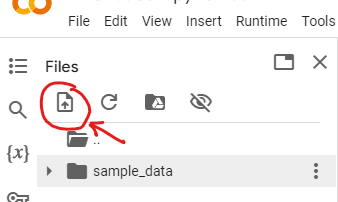


## **Download Images From the Web**

You can also download images from the web. The following `wget` commands download 3 images from the web. You can add more if you wish.

In [ ]:
# Get images from the web
!wget https://cdn2.techbang.com/system/excerpt_images/54164/original/791d4f1acb0144bbd7cd761349230fe3.jpeg -O lena.jpeg
!wget https://as1.ftcdn.net/v2/jpg/03/00/09/16/1000_F_300091669_YYN79gxWZkfxAYxtDuGAipzhqXP6Wcfv.jpg -O rose.jpg
!wget --user-agent="Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36" https://images.pexels.com/photos/1054666/pexels-photo-1054666.jpeg -O elephant_large.jpg

--2025-01-06 16:52:40--  https://cdn2.techbang.com/system/excerpt_images/54164/original/791d4f1acb0144bbd7cd761349230fe3.jpeg
Resolving cdn2.techbang.com (cdn2.techbang.com)... 3.165.102.110, 3.165.102.24, 3.165.102.25, ...
Connecting to cdn2.techbang.com (cdn2.techbang.com)|3.165.102.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90069 (88K) [image/jpeg]
Saving to: ‘lena.jpeg’

lena.jpeg           100%[===================>]  87.96K  --.-KB/s    in 0.1s    

2025-01-06 16:52:41 (629 KB/s) - ‘lena.jpeg’ saved [90069/90069]

--2025-01-06 16:52:41--  https://as1.ftcdn.net/v2/jpg/03/00/09/16/1000_F_300091669_YYN79gxWZkfxAYxtDuGAipzhqXP6Wcfv.jpg
Resolving as1.ftcdn.net (as1.ftcdn.net)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to as1.ftcdn.net (as1.ftcdn.net)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347213 (339K) [image/jpeg]
Saving to: ‘rose.jpg’

rose.jpg            100%[===================>] 


## **Overcoming Limitation of Colab**

There is a slight problem displaying images in Colab. Most OpenCV functions work just fine under Colab. However, Colab does not allow easy way to display images unless the OpenCV program is written in Python language and execute directly in the cell. But, in this exercise, we want to write OpenCV in C++. One way to overcome this is by first saving the images into files in whatever image format you desired and then manually open the images one by one to observe the result.

In this exercise, we want to display the images directly from C++ program. To do this, we will use an interprocess communication protocol called `named pipe` by setting up the channel between the C++ program and a Python code running in the cell. Whenever, the C++ wants to display an image, it sends the image through the pipe and the Python code helps to display it. We need a C++ stub and a Python stub, which act as proxies between our program in C++ and Python.

## **C++ Stub**

The following is the C++ stub, called `cv_pipe` that needs to be compiled together with the C++ program needing the service. [*Note: You don't need it if you wish to run this exercise in the Windows Visual Studio.*]

In [ ]:
# Header file for cv_pipe
%%writefile cv_pipe.h
#pragma once
#include <opencv2/opencv.hpp>
#include <iostream>
#include <unistd.h> // For pipe
#include <fcntl.h>  // For O_WRONLY

#define reset_getopt()    (optind = 0)

int cv_imshow(cv::Mat &image);
int init_cv_pipe_comm(int argc, char *argv[], bool verbose=false);
int finalize_cv_pipe_comm();

Writing cv_pipe.h


In [ ]:
%%writefile cv_pipe.cpp
#include "cv_pipe.h"

static int fd = -1;

int open_named_pipe(char *pipe_name) {
    fd = open(pipe_name, O_WRONLY);
    if(fd < 0) {
        std::cerr << "Error: failed to open the named pipe: "
                  << pipe_name << std::endl;
    }
    return fd;
}

int cv_imshow(cv::Mat &image) {
    if(fd < 0) {
        std::cerr << "Error: no named pipe available." << std::endl;
        return -1;
    }
    // Send image size as a header
    int img_size[3] = {image.cols, image.rows, image.channels()};
    write(fd, img_size, sizeof(img_size));
    // Send the image data
    write(fd, image.data, image.total() * image.elemSize());
    return 0;
}

int init_cv_pipe_comm(int argc, char *argv[], bool verbose) {
    int c;
    char *pipe_path = NULL;

    if(verbose) {
        // Print all input arguments
        for(int i = 0; i < argc; i++) {
            std::cout << "[" << i << "] " << argv[i] << std::endl;
        }
    }
    //opterr = 0;       // Do not print error to stderr
    while ((c = getopt(argc, argv, ":p:")) != -1) {
        switch(c) {
            case 'p':
                pipe_path = optarg;
                break;
            case ':':
                std::cerr << "Error: option -" << static_cast<char>(optopt)
                          << " requires an argument.\n";
                return -1;
            case '?':
                // Ignore all unknown options; let the main program handles it.
                break;
        }
    }
    if(!pipe_path) {
        std::cerr << "Error: expect a pipe name but none found. Try the "
                  << "following:\n\t" << argv[0] << " -p my_pipe\n";
        return -1;
    }

    fd = open_named_pipe(pipe_path);
    return fd;
}

int finalize_cv_pipe_comm() {
    close(fd);        // Close the write end of the pipe
    return 0;
}

Writing cv_pipe.cpp


## **Python Stub**

The following is the Python stub, called `runner` that we need to invoke the compiled C++ program and help display the images sent by the C++ program. [*Note: You don't need it if you wish to run this exercise in the Windows Visual Studio.*]

In [ ]:
%%writefile runner.py
import os, sys, subprocess
import threading
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def tee_pipe(pipe, out):
    for line in pipe:
        #print(line.decode('utf-8'), end='')
        #print(line.decode('utf-8'), end='',  file=out)
        out.write(line.decode('utf-8'))

def execute(filename, *args, pipe_name='/tmp/my_pipe'):
    if not os.path.exists(pipe_name):
        os.mkfifo(pipe_name)

    # Start the subprocess. The -u option is to force the Python subprocess
    # to flush its output everytime it prints.
    proc = subprocess.Popen(
            [filename, '-p', pipe_name, *args],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
    )
    # Create threads to capture and print stdout and stderr
    t1 = threading.Thread(target=tee_pipe, args=(proc.stdout, sys.stdout))
    t2 = threading.Thread(target=tee_pipe, args=(proc.stderr, sys.stdout))
    t1.start()
    t2.start()

    with open(pipe_name, "rb") as pipe:
        while True:
            # Read the image size from the pipe
            # The 1st 4 byte is column size
            # The 2nd 4 byte is row size
            # The 3rd 4 byte is channel size
            img_header = pipe.read(12)
            if not img_header:
                break
            image_size = np.frombuffer(img_header, dtype=np.uint32)
            # Read the image data for all channels
            frame_data = pipe.read(image_size[0] * image_size[1] * image_size[2])
            if not frame_data:
                break
            frame = np.frombuffer(frame_data, dtype=np.uint8).reshape((image_size[1], image_size[0], image_size[2]))
            # Display the received frame
            cv2_imshow(frame)

    proc.wait()                 # Wait for subprocess to exit
    os.remove(pipe_name)        # Clean up the named pipe
    cv2.destroyAllWindows()

Writing runner.py


## **Main C++ Program**

This is the main C++ called `cuda_grayscale.cpp`. In OpenCV, each pixel of an RGB color is stored in this order: `blue`, `green`, and `red`, where each color channel is 8-bit in size and blue is stored in the lowest address. The pixels are stored in the `data` of the `image` object. The colors are called channels.

The `image` object also stores metadata of the image it holds. The metadata can be obtained through its public data or by calling the methods of the `image` object. For example:

*   `image.cols` returns the total number of pixels in x axis
*   `image.rows` returns the total number of pixels in y axis
*   `image.channels()` returns the total number of channels/colors of a pixel

The `cuda_grayscale.cpp` program contains the `main()` function and is pretty much complete. So, you don't have to add code here.

In [ ]:
%%writefile cuda_grayscale.cpp
#include <opencv2/opencv.hpp>
#include <iostream>
#include <vector>
#include "cv_pipe.h"
#include "grayscale.cuh"

/**
 * Allocate image memory for the `out_img`, which is the grayscale image and
 * then call the CUDA code to do the conversion. The size of grayscale image
 * is the same as the `in_img`, which is the BGR-color image
 */
cv::Mat &color_to_grayscale(cv::Mat &out_img, cv::Mat &in_img) {
    const int cols = in_img.cols, rows = in_img.rows;
    const int channels = in_img.channels();
    // Allocate memory to store grayscale image. The number of columns and
    // rows (in pixels) are the same as the color image, but only 1 color
    // channel of uint8_t type
    out_img.create(rows, cols, CV_8U);
    // Do memory transfer of the image from the host to device then launch the
    // CUDA kernel
    cuda_color_to_grayscale(out_img.data, in_img.data, cols, rows, channels);
    return out_img;
}

int main(int argc, char *argv[]) {
    int c;
    std::vector<char *> img_filenames;
    init_cv_pipe_comm(argc, argv, true);

    reset_getopt();
    while ((c = getopt(argc, argv, "p:")) != -1) {
        switch (c) {
            case 'p':
                // Do nothing because it should be handled by cv_pipe
                break;
            case '?':
                // Abort when encountering an unknown option
                return -1;
        }
    }
    // Get all filenames from the non-option arguments
    for (int index = optind; index < argc; index++)
        img_filenames.push_back(argv[index]);

    for(auto filename: img_filenames) {
        std::cout << filename << std::endl;
        // Load the filename image
        cv::Mat image = cv::imread(filename);
        if (image.empty()) {
            std::cerr << "Unable to load image: " << filename << std::endl;
            return -1;
        }
        cv::Mat gray_img;
        // Convert color image to grayscale image
        gray_img = color_to_grayscale(gray_img, image);
        cv_imshow(gray_img);
    }

    return finalize_cv_pipe_comm();
}

Writing cuda_grayscale.cpp


In [ ]:
%%writefile grayscale.cuh
#pragma once

#ifdef __CUDACC__
__global__ void to_grayscale_kernel(uint8_t *gray_img, uint8_t *bgr_img,      \
                                    int width, int height);
#endif

void cuda_color_to_grayscale(uint8_t *gray_img, uint8_t *color_img, int width,\
                                    int height, int channels);

Writing grayscale.cuh


## **CUDA Program**

This CUDA program needs to be completed by you. Follow the instructions in the
comments to make this program complete.

Original Program (Question - Fill in the blank)

In [ ]:
%%writefile grayscale.cu
#include <iostream>
#include <cuda_runtime.h>
//#include <cuda.h>
//#include <device_launch_parameters.h>
#include "grayscale.cuh"

__global__ void to_grayscale_kernel(uint8_t *gray_img, uint8_t *bgr_img,
                                    int width, int height, int channels) {
    // Add your code here to turn the color image into grayscale image
    // Note: gray = 0.07 * blue + 0.71 * green + 0.21 * red
    // ...
}

const int thread_per_blk = 32;      // Use 32 threads per block for x and y
void cuda_color_to_grayscale(uint8_t *gray_img, uint8_t *color_img,
                              int width, int height, int channels) {
    uint8_t* cData;       // Color image data for device
    uint8_t* gData;       // Grayscale image data for device

    // Compute the image data size for color and grayscale in bytes. Note that
    // the gray scale image has only one channel (one color), so the size is
    // 3 times smaller.
    const size_t grayDataSize = sizeof(uint8_t) * width * height;
    const size_t colorDataSize = grayDataSize * channels;

    // Allocate memory for gData and cData with the size of grayDataSize
    // and colorDataSize, respectively
    //cudaMalloc(?, ?);
    //cudaMalloc(?, ?);

    // Transfer BGR image from host (color_img) to device (cData). The size
    // should be colorDataSize
    //cudaMemcpy(?, ?, ?, ?);

    // Calculate blocksize and gridsize, use the recommended 'thread_per_blk'
    //dim3 blockSize(?, ?, ?);
    //dim3 gridSize(?, ?);

    // Call the GPU kernel
    //to_grayscale_kernel <<<?, ?>>> (gData, cData, width, height, channels);

    // Transfer Grayscale image from device (gData) to host (gray_img). The
    // size should be colorDataSize
    //cudaMemcpy(?, ?, ?, ?);

    // Free the allocated device memory
    //cudaFree(?);
    //cudaFree(?);
}

Writing grayscale.cu


Solution Program

In [ ]:
%%writefile grayscale.cu
#include <iostream>
#include <cuda_runtime.h>
//#include <cuda.h>
//#include <device_launch_parameters.h>
#include "grayscale.cuh"

__global__ void to_grayscale_kernel(uint8_t *gray_img, uint8_t *bgr_img,
                                    int width, int height, int channels) {
    // Add your code here to turn the color image into grayscale image
    // Note: gray = 0.07 * blue + 0.71 * green + 0.21 * red
    // uint8_t = unsigned 8-bit integer type (Range: 0 - 255)
    // static_cast<uint8_t>(value) -> // Explicitly cast to uint8_t

    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;

    if (x < width && y < height){
      int gray_idx = y * width + x;
      int color_idx = gray_idx * channels;

      // Get BGR pixel
      uint8_t blue = bgr_img[color_idx];
      uint8_t green = bgr_img[color_idx + 1];
      uint8_t red = bgr_img[color_idx + 2];

      gray_img[gray_idx] = static_cast<uint8_t>(0.07 * blue + 0.71 * green + 0.21 * red);
    }
}

const int thread_per_blk = 32;      // Use 32 threads per block for x and y
void cuda_color_to_grayscale(uint8_t *gray_img, uint8_t *color_img,
                              int width, int height, int channels) {
    uint8_t* cData;       // Color image data for device
    uint8_t* gData;       // Grayscale image data for device

    // Compute the image data size for color and grayscale in bytes. Note that
    // the gray scale image has only one channel (one color), so the size is
    // 3 times smaller.
    const size_t grayDataSize = sizeof(uint8_t) * width * height;
    const size_t colorDataSize = grayDataSize * channels;

    // Allocate memory for gData and cData with the size of grayDataSize
    // and colorDataSize, respectively
    cudaMalloc((void**)&cData, colorDataSize);
    cudaMalloc((void**)&gData, grayDataSize);

    // Transfer BGR image from host (color_img) to device (cData). The size
    // should be colorDataSize
    cudaMemcpy(cData, color_img, colorDataSize, cudaMemcpyHostToDevice);

    // Calculate blocksize and gridsize, use the recommended 'thread_per_blk'
    dim3 blockSize(thread_per_blk, thread_per_blk, 1);
    dim3 gridSize((width + thread_per_blk - 1) / thread_per_blk,
                    (height + thread_per_blk - 1) / thread_per_blk);

    // Call the GPU kernel
    to_grayscale_kernel <<<gridSize, blockSize>>> (gData, cData, width, height, channels);

    // Transfer Grayscale image from device (gData) to host (gray_img). The
    // size should be colorDataSize
    cudaMemcpy(gray_img, gData, grayDataSize, cudaMemcpyDeviceToHost);

    // Free the allocated device memory
    cudaFree(cData);
    cudaFree(gData);
}

Overwriting grayscale.cu


## **Compiling the Main C++ Program**

The main C++ program `cuda_grayscale.cpp` needs to be compiled with the `cv_pipe.cpp` file.  Also, we need to compile with the OpenCV headers and libraries and this is handled by the `pkg-config --cflags --libs opencv4` command. We get `pkg-config` to go figure out what those are for us. The output file is named as `cuda_grayscale` without an extension name.

In [ ]:
!nvcc -o cuda_grayscale cuda_grayscale.cpp grayscale.cu cv_pipe.cpp `pkg-config --cflags --libs opencv4`

## **Running the Main C++ Program through Python Code**

Finally, we need to run the C++ program as a subprocess of a Python program so that the C++ program can display the images directly in the cell.

The first statement is to import the `execute()` function in the `runner.py` written above. The `execute()` function runs the compiled C++ program in the cell. The 1st parameter of function is the name of the program you wish to run. All subsequent parameters are the input arguments you want to pass to the program. In our case, we pass in 2 names of images we downloaded earlier.  

Note that running this exercise requires GPU and for a non-paid user like us, we are given only a few hours of compute usage. So if you are not running the code, I suggest to disconnect the runtime.


[0] ./cuda_grayscale
[1] -p
[2] /tmp/my_pipe
[3] lena.jpeg
[4] rose.jpg
lena.jpeg
rose.jpg


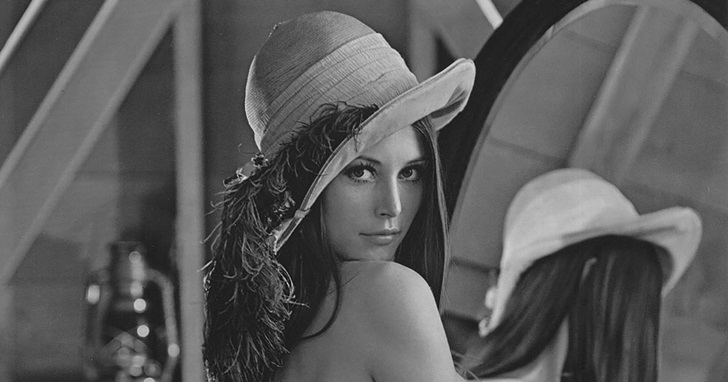

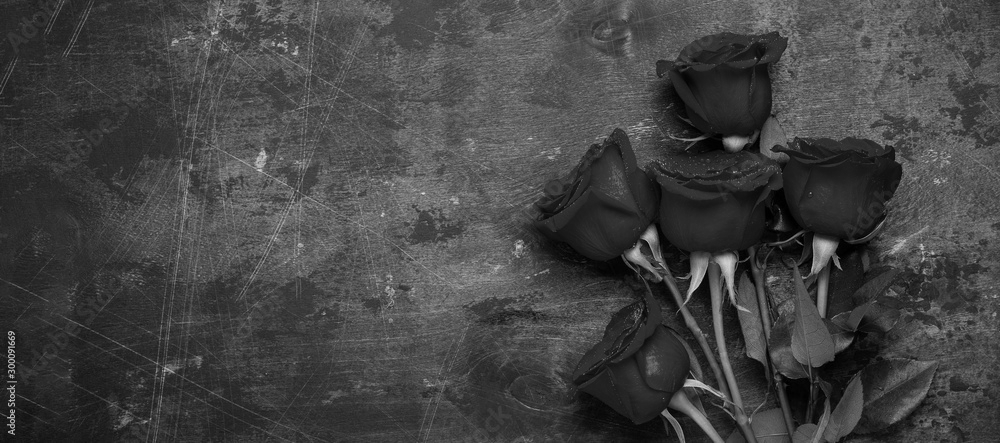

In [19]:
from runner import execute

execute(
    # Execute the program `cuda_grayscale` we compiled above
    "./cuda_grayscale",
    # Pass the 2 (out of 3) image filenames downloaded from the web
    "lena.jpeg", "rose.jpg",
)